In [1]:
%load_ext autoreload
%autoreload 2

# Large-scale Content-Based Image Retrieval
---

This is how we would implement a CBIR model.  
We will divide the CBIR into different functionalities and address each functional block as we go through the notebook. In the last part of the session, we will put everything together.

In [2]:
class CBIR:
    def __init__(self, dataset):
        self.dataset = dataset
        self.index = None  # we haven't built an indexed database yet
        return
    
    # >> TASK 1
    def find_keypoints(self, image):
        # Implement me using Maximally Stable Extremal Region
        raise NotImplemented
        # return keypoints on image
        
    # >> TASK 2
    def extract_features(self, image):
        # Implement me using Scale Invariant Feature Transform
        raise NotImplemented
        # return a list of 128-vector features
    
    # >> TASK 3
    def create_vocabulary(self):
        # Implement me using Hierarchical kmeans, Bag of Visual Word, and Term Frequency-Inverse Document Frequency (TF-IDF)  
        raise NotImplemented
        # return the tree and the index

    # >> TASK 4
    def encode(self, image):
        # Implement me using vocabulary tree, please
        raise NotImplemented
        # return the vector representation of an image
    
    # >> TASK 5
    def score(self, image_a, image_b):
        raise NotImplemented
        # return the similarity score between two images
    
    # >> TASK 6
    def retrieve(self, query_image):
        # this is the function we have described above
        raise NotImplemented
        # return the most similar images to the query image

<br>

## **Chapter 2: Creating a visual vocabulary**
---

<div style="margin:auto; float:right; margin-left: 50px; width: 60%">
<!--     <center>How we construct this vector is key for the retrieval performance</b></center> -->
<center>
    <b><i>The tree directly defines the visual vocabulary
    and an efficient search procedure in an integrated
        manner.</b></i>
    </center>
<img src="images/tree_structure.png">
</div>
<br>
    
<p style="color: #a00; font-weight: 700">>> TASK 3</p>

> In this section we are going to learn how to implement the function:
```python
# >> TASK 3
def create_vocabulary(features):
    # Implement me using Hierarchical kmeans
    # return the tree and the index
```

In this section we provide a structure to the set of image representations collected in **1.2**.  
We implement the [**Vocabulary tree structure**](https://ieeexplore.ieee.org/document/1641018) illustrated by Nister [ref], which uses Hierarchical KMeans to build the tree, and Term Frequency-Inverse Document Frequency to index each sample of the database.

<br>  
<center>

> ***Recipe:***   
> ***2.1.*** Building the tree using hierarchical k-means   
> ***2.2*** ***Indexing*** the database using TF-IDF (Term Frequency-Inverse Document Frequency)   
> ***2.3*** ***Scoring*** two images   
> ***2.4*** ***Retrieving*** similar images   

<br>

### 2.1 Building the tree using hierarchical k-means
---

<br>
<div style="margin:auto; float:left; margin-right: 50px; width: 33%;">
<img src="images/kmeans.png">
<!-- <em>Add image caption with reference</em> -->
</div>
<br>

In this section we are going to hierarchically separate the features into clusters using ***hierarchical k-means***.

`k` defines the branch factor (number of
children of each node) of the tree. First, an initial k-
means process is run on the training data, defining k cluster
centers. The training data is then partitioned into k groups,
where each group consists of the descriptor vectors closest
to a particular cluster center.

The procedure is applied recursively on each of the clusters, until we reach a depth `L`.


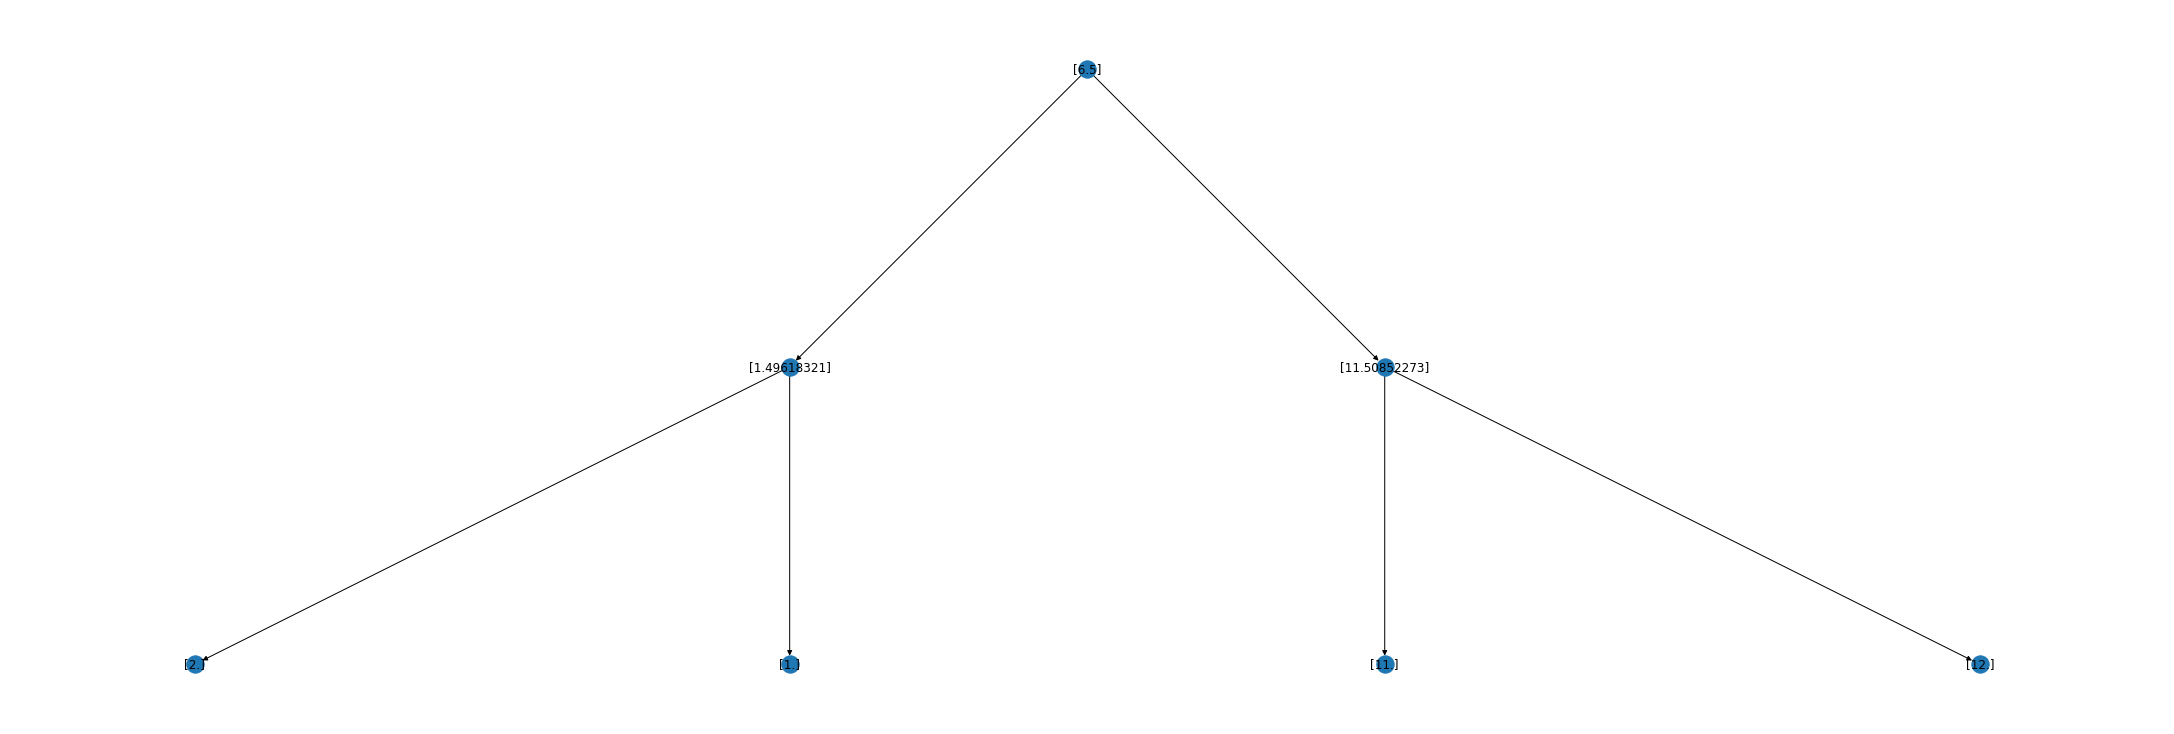

In [11]:
from cbir import CBIR
import numpy as np

# initialise the database
database = CBIR("data/jpg", n_branches=2, depth=2)

# perform hierarchical k-means clustering on the features
features = np.array([[1.], [2.], [11.], [12.]])
database.fit(features)

# plot the graph
fig = database.draw(labels=database.nodes)

- The internal nodes of the tree are the cluster centers
- The leaves of the node are the features we started from



Try it out with your own features now. Remember:
- `n_branches` controls how many nodes to create from a parent node (`k` in the picture above)
- `depth` controls the number of levels in the tree (`L` in the picture above)

In [16]:
n_branches = 2
depth = 4

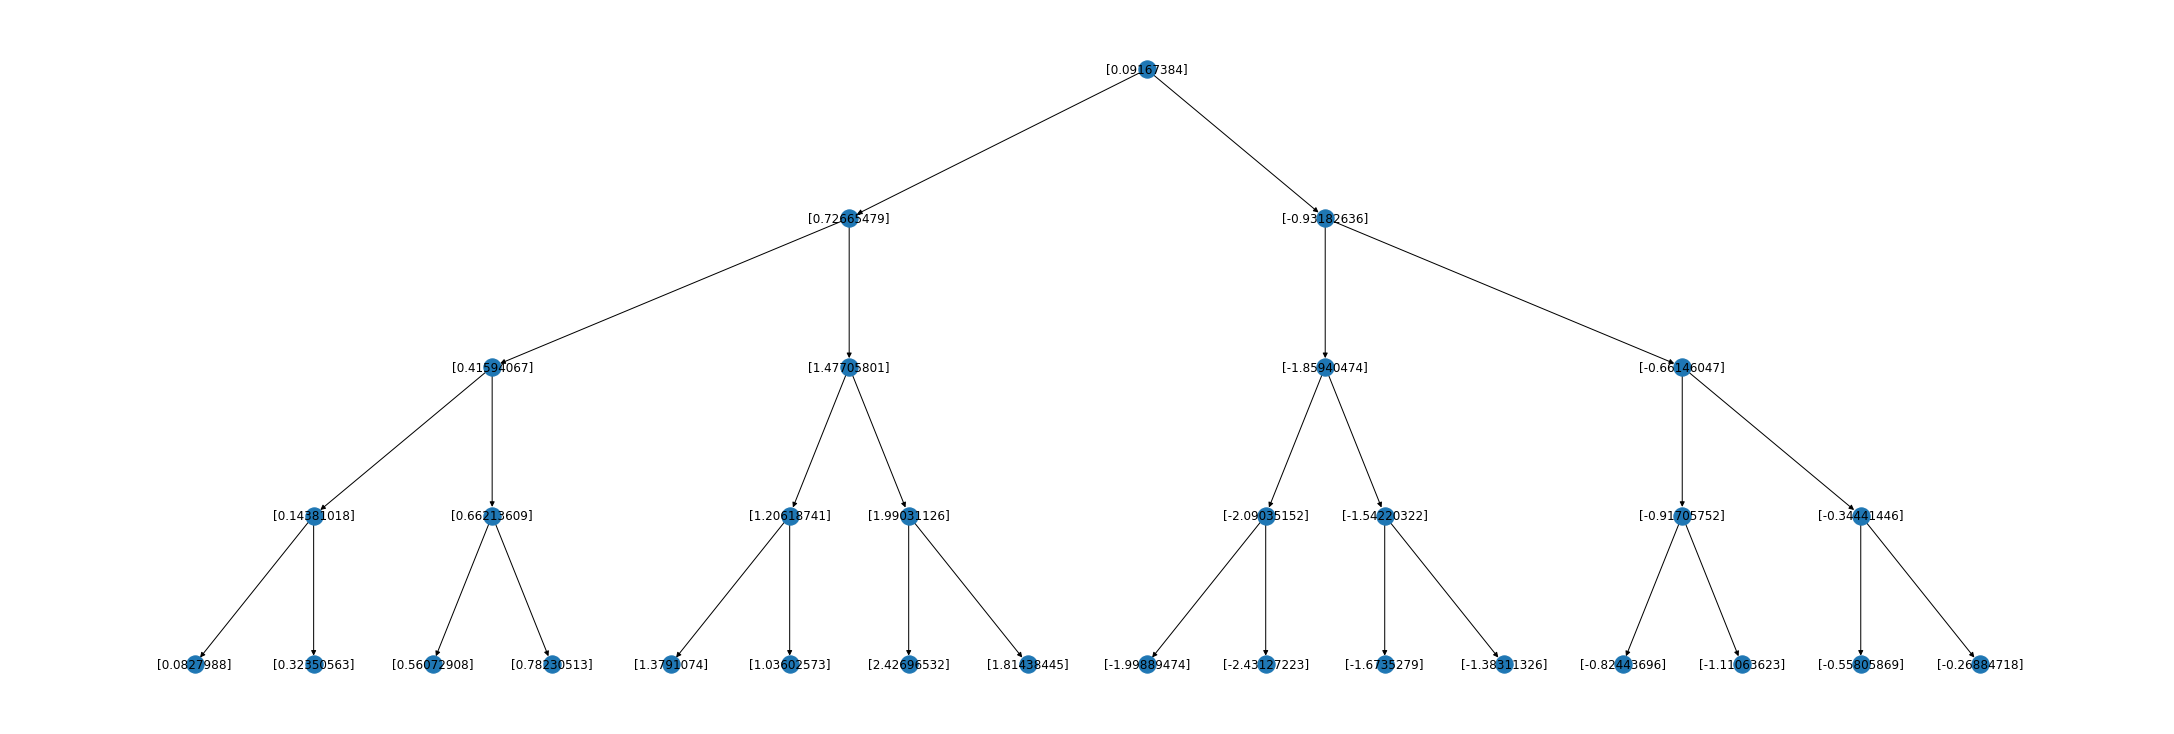

In [17]:
# initialise the database
database = CBIR("data/jpg", n_branches=n_branches, depth=depth)

# perform hierarchical k-means clustering on the features
database.fit(np.random.randn(100, 1))

# plot the graph
fig = database.draw(figsize=(30, 10), labels=database.nodes)

<br> 

### 2.2 Indexing the database using TF-IDF (Term Frequency-Inverse Document Frequency)
---

<div style="margin:auto; float:right; margin-roght: 50px; width: 40%">
<img src="images/index.png">
<!-- <em>Add image caption with reference</em> -->
</div>
<br>


Indexing is the process of building and storing a **database table** to perform efficient **lookups**, i.e. to quickly find a specific database element.  
In the image retrieval problem we store an index that associates an image, with its vector representation: **`image: vector`**



<p style="color: #a00; font-weight: 700">>> TASK 4</p>

> In this section we are going to learn how to implement the function:
```python
def encode(dataset):
    return indexed_database
```

In this section we provide a structure to the set of image representations collected in **1.2**.  
We implement the [**Vocabulary tree structure**](https://ieeexplore.ieee.org/document/1641018) illustrated by Nister [ref], which uses inverted indices and hierarchical k-means to build the graph.

> ***Recipe:***  
> 1. Given an image, for each feature, we propagate the feature down the tree.   
> 2. We start from the root of the tree, and find the closest node among its children nodes.  
> 3. We apply the same procedure until we reach the bottom of the tree, a leaf.  
> 4. Every time we pass through a node, we register the passage by adding +1 to the node, for that specific image.  

<br>
<div style="margin:auto; float:left; margin-right: 50px; width: 45%;">
    <center>
    <b>Feature #1</b>
        <br>
    </center>
<img src="images/encoded_a.png">
</div>
<div style="margin:auto; float:right; margin-left: 50px; width: 45%;">
    <center>
    <b>Feature #2</b>
        <br>
    </center>
<img src="images/encoded_b.png">
</div>
<br>
<br>
<div style="margin:auto; float:left; margin-right: 50px; width: 45%;">
        <center>
            <b>...</b>
            <br>
    <b>Feature #3</b>
    </center>
<img src="images/encoded_c.png">
</div>
<div style="margin:auto; float:right; margin-left: 50px; width: 45%;">
        <center>
            <b>...</b>
            <br>
    <b>Feature #4</b>
    </center>
<img src="images/encoded_d.png">
</div>

<!-- <em>Add image caption with reference</em> -->
</div>
<br>

<div style="margin:auto; float:center; width: 55%;">
    <br>
    <center>
        When we have propagated all the features, we count the number of passages at each node.     
        <b>This represents our encoded image</b>    
    </center>
    <img src="images/encoded_all.png">
</div>
 

This results into a tf-idf scheme: when we cross a node, we leave a fingerprint on the node:

In [18]:
# let's take a look at how we can encode an image
image_id = "142000"

Image as perceived by us:


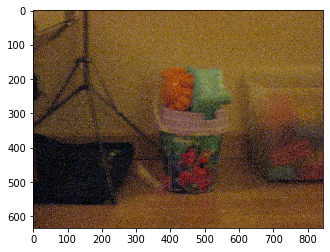

Image embedding as graph:


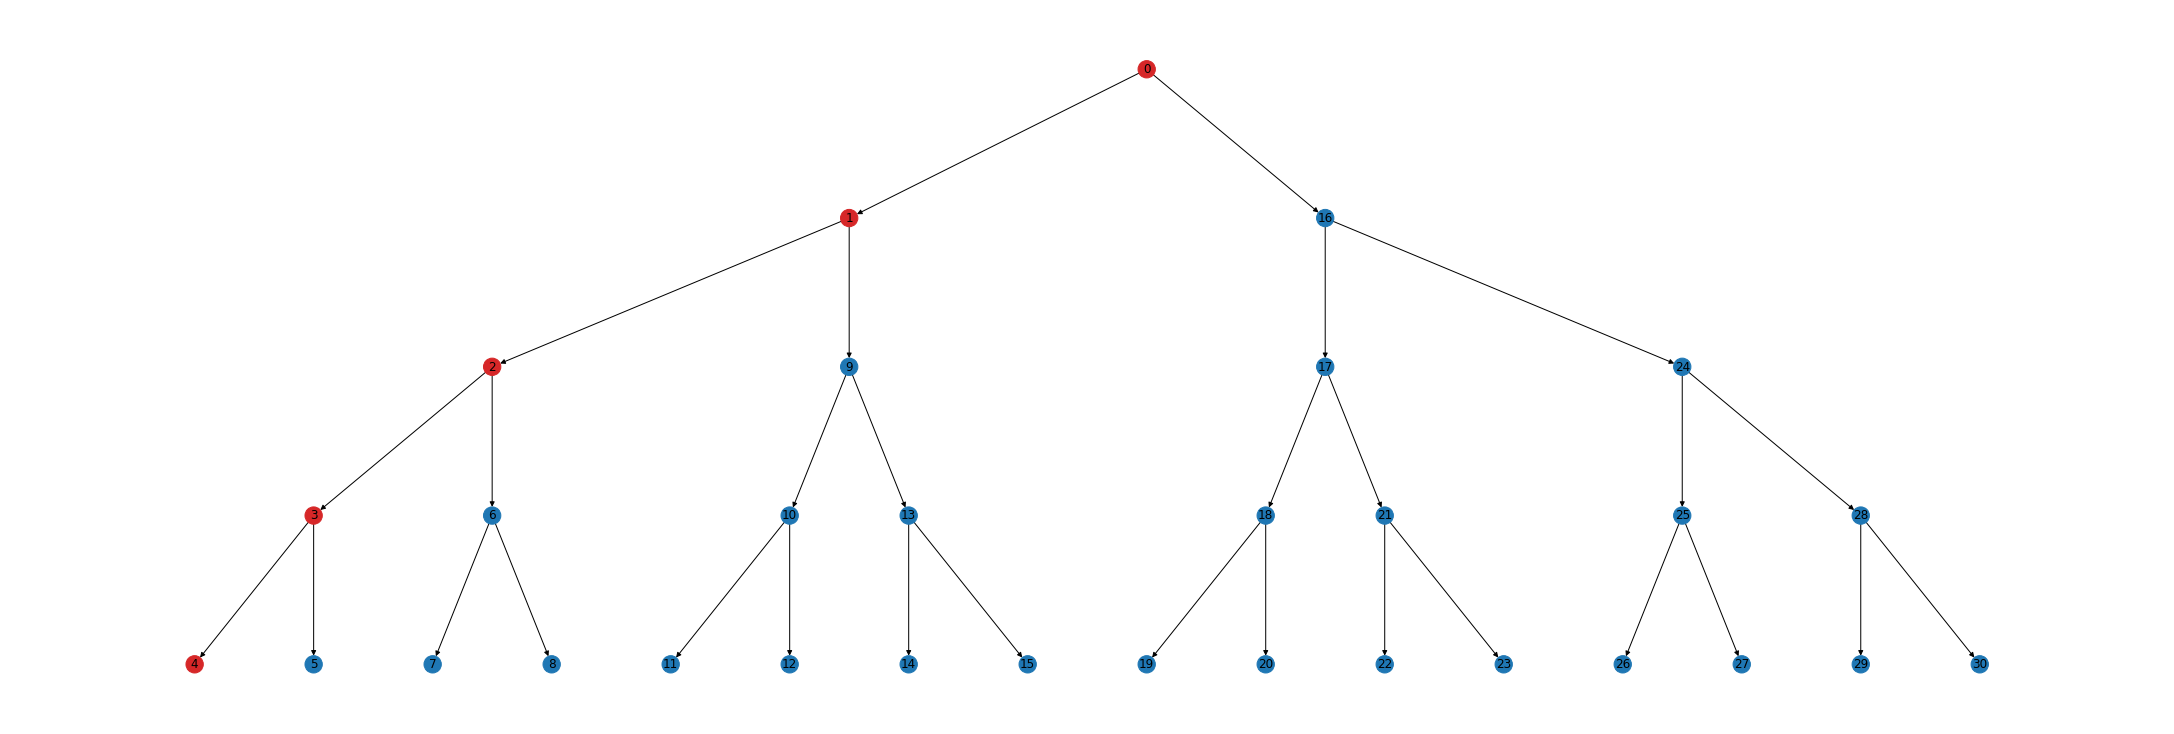


Image embedding as vector: [0.2 0.2 0.2 0.2 0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ] 



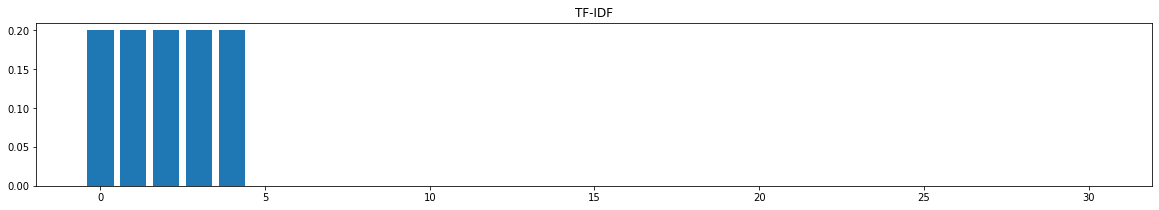

In [19]:
import matplotlib.pyplot as plt

# let's see the images we are encoding
database.dataset.show_image(database.dataset.read_image(image_id + ".jpg"))
print("Image as perceived by us:")
plt.show()

# as a graph
database.propagate(image_id + ".jpg")
database.encode(image_id, return_graph=True)
print("Image embedding as graph:")
plt.show()

# and its corresponding vector
database.propagate(image_id + ".jpg")
embedding = database.encode(image_id)
print("\nImage embedding as vector:", embedding, "\n")
fig = plt.figure(figsize=(20, 3))
plt.bar(np.arange(len(embedding)), embedding)
plt.gca().set_title("TF-IDF")
plt.show()

> ***Action:*** Change the `image_id` above and try encoding a different image

<br>

## **Chapter 3. Scoring and Retrieving (the online phase)**
---

<!-- <div style="margin-left: 230px"> -->
<br>

<div style="margin:auto; float:right; margin-left: 50px; width: 30%">
<img src="images/image_similarity.jpg">
</div>
<br>
    

<p style="color: #a00; font-weight: 700">>> TASK 5</p>

> In this section we are going to learn how to implement the function:
```python
def score(database, image):
    return score
```

The objective of scoring is to compare two images in their embedding form, and return a measure of their **similarity**.

Once the quantization is defined, we wish to determine
the relevance of a database image to the query image based
on how similar the paths down the vocabulary tree are
for the descriptors from the database image and the query
image.

<br>

  

Let's grab two images from the database and get their embeddings


Image 1 embedding: [0.2 0.2 0.2 0.2 0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]


Image 2 embedding: [0.2 0.2 0.2 0.2 0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]


Text(0.5, 1.0, 'Image 2 TF-IDF')

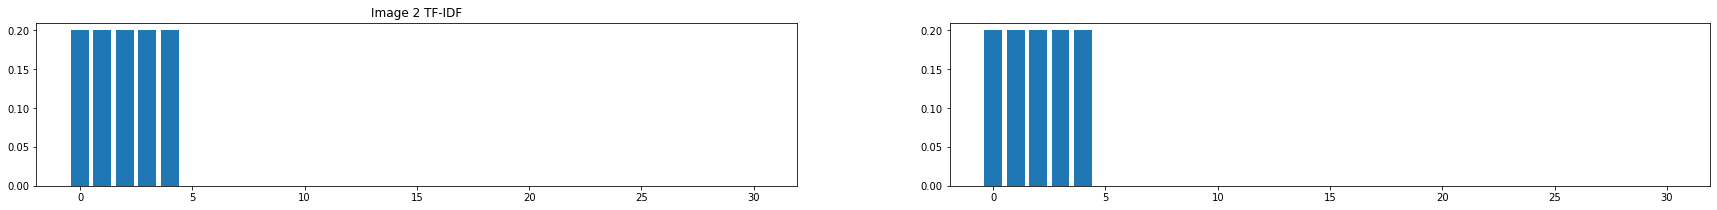

In [20]:
# take two images by using their ids
image_id_1 = "120000"
image_id_2 = "104000"

# let's propagate the images down the tree first
database.propagate(image_id_1 + ".jpg")
database.propagate(image_id_2 + ".jpg")

# and then get their embeddings
em_1 = database.encode(image_id_1)
em_2 = database.encode(image_id_2)

print("\nImage 1 embedding:", em_1)
print("\n\nImage 2 embedding:", em_2)

fig, ax = plt.subplots(1, 2, figsize=(30, 3))
ax[0].bar(np.arange(len(em_1)), em_1)
ax[0].set_title("Image 1 TF-IDF")
ax[1].bar(np.arange(len(em_2)), em_2)
ax[0].set_title("Image 2 TF-IDF")

<br>
We can also look at their graph representations

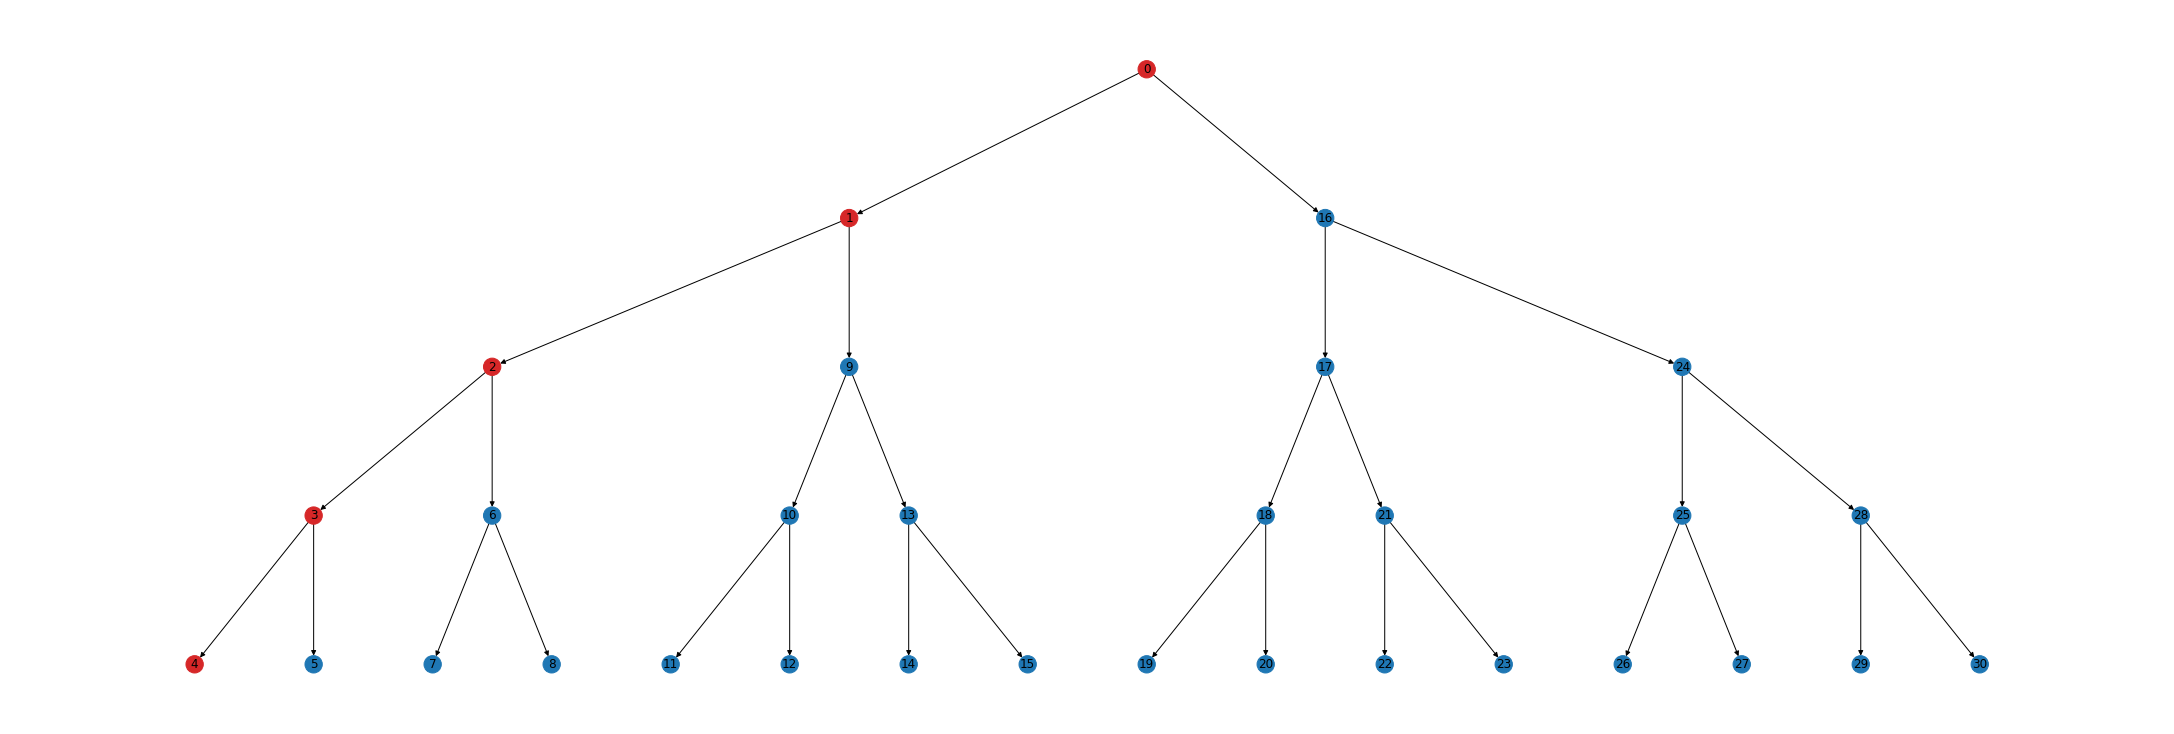

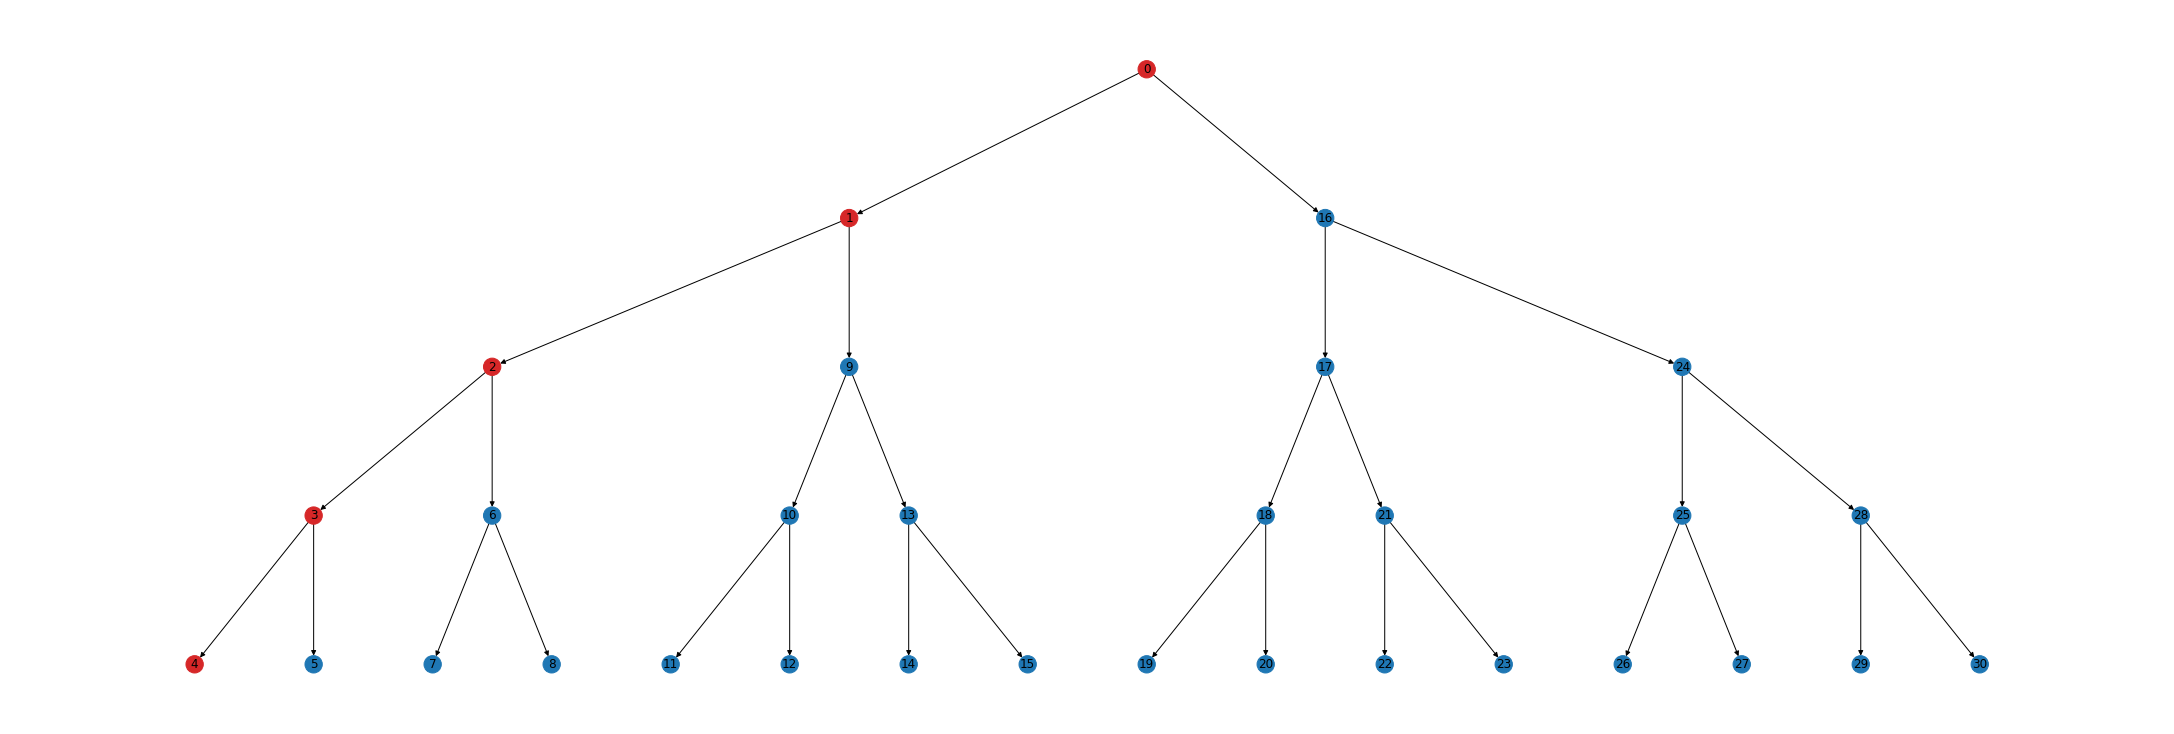

In [21]:
database.encode(image_id_1, return_graph=True)
database.encode(image_id_2, return_graph=True)

<center>
    In this implementation, to measure the score between two images we use <b>L1-norm</b>
    </center>

\begin{align}
MAE(x_1, x_2) = \frac{1}{n}\sum\ | x_{1_i} - x_{2_i} | \\
\end{align}

In [22]:
# let's now try to score the two images
# the function askes for two paths to the two images to score against
image_1 = "data/jpg/104000.jpg"
image_2 = "data/jpg/104002.jpg"

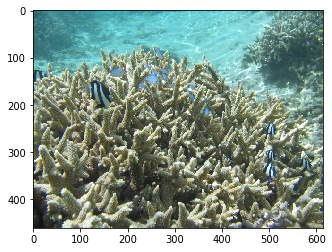

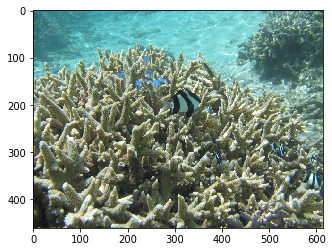

In [23]:
# let's plot them
database.dataset.show_image(database.dataset.read_image(image_1))
plt.show()
database.dataset.show_image(database.dataset.read_image(image_2))

In [24]:
# and now let's score them
score = database.score(image_1, image_2)
print("Score is:", score)

Score is: 1.0


/home/ep119/repos/sberbank/cbir.py:189: RuntimeWarning: invalid value encountered in true_divide
  norm = np.linalg.norm(embedding, ord=1)  # l1 norm


> ***Action:*** try changing the images above and see how the score changes

<br>

### 3.2 Retrieving an image from the database
---
Here we bring together all the concepts we have illustrated above to build our Large-Scale CBIR system.

In [30]:
# Let's create the database
database = CBIR(root="data/jpg", n_branches=4, depth=4, sift_implementation="ezsift")

In [31]:
# Now, let's extract the features
features = database.extract_features()

Extracting features 1491/1491 from image 122800.jpg - ETA: 0.000000s
1239134 features extracted


In [27]:
# We can now train the tree using the extracted features
database.fit(features)

In [28]:
# And we can index all the images
# you can use database.tfidf() to index all the images at once
database.tfidf()


Generating index


/home/ep119/repos/sberbank/cbir.py:189: RuntimeWarning: invalid value encountered in true_divide
  norm = np.linalg.norm(embedding, ord=1)  # l1 norm


Indexing image 1492/1491:  122800.jpg - ETA: 0.000000ss
Calculating weights
Inverted index generated


In [ ]:
# and we can retrieve the most similar image, given a query one
query = "104000.jpg"
query_image = database.dataset.read_image(query)
database.dataset.show_image(query_image)

In [ ]:
scores = database.retrieve(query)
database.show_results(query, scores, figsize=(30, 10))

<br>

## **[Optional] Chapter 4. Image encoding with Deep Convolutional Neural Networks**
---

The excercises below this point are not mandatory. They provide a wider picture on how to build an efficient image representation.
We will illustrate how to use a pretrained image classifier to represent the features of an image
- 4.1 Using pretrained deep artificial neural networks to build a representation of the image
- 4.2 Fine tune a pretrained model on our database

**4.1 Using a pre-trained network**

In this optional assignement, we are going to replace the SIFT 128-vectored features, with the latent space from *[AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)*

In [32]:
# let's download a pretrained version of AlexNet from torchvision
import torch
import torchvision
import matplotlib.pyplot as plt
alexnet = torchvision.models.alexnet(pretrained=True)

<BarContainer object of 1000 artists>

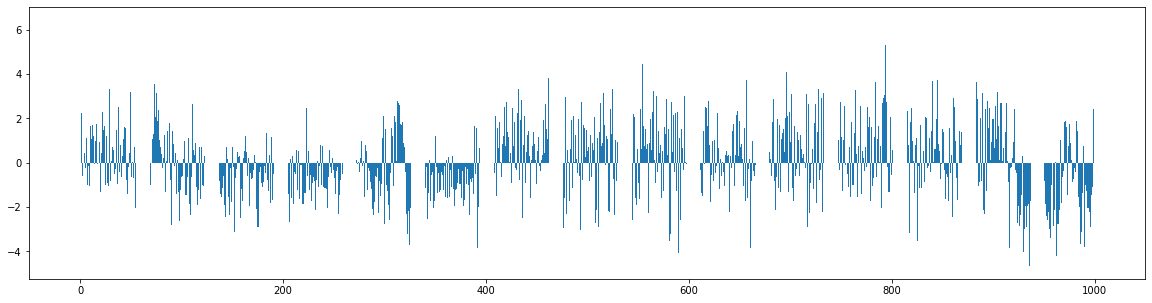

In [33]:
image = database.dataset.get_random_image()
image = torch.as_tensor(image, dtype=torch.float32) / 255
image = image.permute(2, 1, 0)
with torch.no_grad():
    encoded = alexnet(torch.as_tensor(image).unsqueeze(0)).squeeze().numpy()

plt.figure(figsize=(20, 5))
plt.bar(np.arange(len(encoded)), encoded)

In [34]:
database_cnn = CBIR("data/jpg", n_branches=5, depth=5, sift_implementation="alexnet")

In [35]:
database_cnn.tfidf()


Generating index
Indexing image 1492/1491:  122800.jpg - ETA: 0.000000ss
Calculating weights
Inverted index generated


<BarContainer object of 1000 artists>

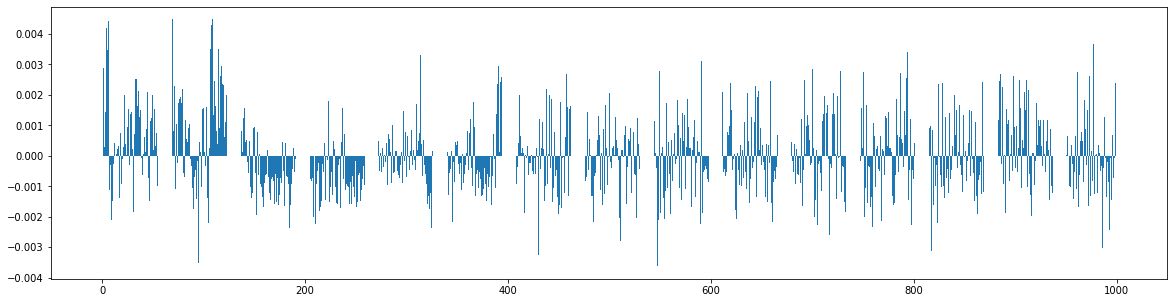

In [36]:
embedding_cnn = database_cnn.encode("104000", return_graph=False)

plt.figure(figsize=(20, 5))
plt.bar(np.arange(len(embedding_cnn)), embedding_cnn)

In [83]:
import random
query = random.choice(database_cnn.dataset.all_images)

In [93]:
def score(self, first_image_path, second_image_path):
    """
    Measures the similatiries between the set of paths of the features of each image.
    """
    # get the vectors of the images

    db_id = self.dataset.get_image_id(first_image_path)
    query_id = self.dataset.get_image_id(second_image_path)
    d = self.encode(db_id, return_graph=False)
    q = self.encode(query_id, return_graph=False)

    # simplified scoring using the l2 norm
    score = np.linalg.norm(d - q, ord=2)
    return score if not np.isnan(score) else 1e6

def retrieve(self, query_image_path, n=4):
    # propagate the query down the tree
    self.propagate(query_image_path)

    scores = {}
    for database_image_path in self.dataset.all_images:
        db_id = self.dataset.get_image_id(database_image_path)
        scores[db_id] = score(self, database_image_path, query_image_path)
    sorted_scores = {k: v for k, v in sorted(
        scores.items(), key=lambda item: item[1])}
    return sorted_scores


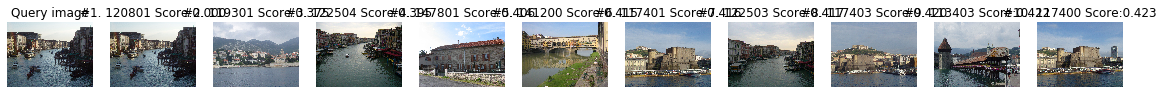

In [92]:
scores = retrieve(database_cnn, query)
database_cnn.show_results(query, scores, figsize=(20, 10), n=10)

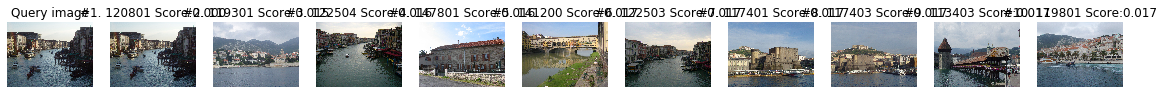

In [95]:
scores = retrieve(database_cnn, query)
database_cnn.show_results(query, scores, figsize=(20, 10), n=10)

In [52]:
database = CBIR("data/jpg", n_branches=5, depth=5, sift_implementation="ezsift")
database.load()

True

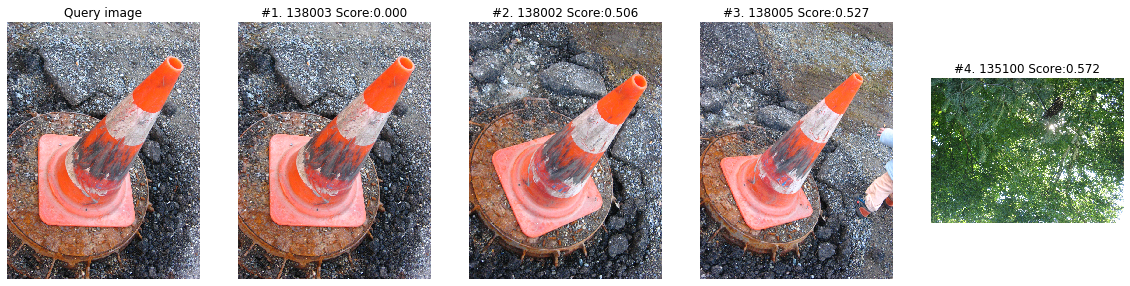

In [71]:
scores = database.retrieve(query)
database.show_results(query, scores, figsize=(20, 10))